In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv

# Birth Death Reaction

$ \varnothing \stackrel{k_1}\longrightarrow M $

$ M \stackrel{k_2}\longrightarrow \varnothing $

BUT: reaction rate constants are not the rates of the chain, death rate is proportional to the number of molecules = $ k_2 * m $

# Simulation: Paths and Bootstrap

In [3]:
def sample_path(x0, params, tmax, plot=False):
    """
    Simulate sample path of birth death reaction

    x0 = initial state
    params = [k1, k2]
    tmax = time of simulation

    return states visited and jump times
    """

    # parameters
    k1 = params[0]
    k2 = params[1]

    # initialise time and state (also store jump times)
    t = 0
    path = [x0]
    jump_times = [0]

    # simulate until stopping time
    while t < tmax:

        # current state
        x = path[-1]

        # rates
        q_birth = k1
        q_death = k2 * x
        q_hold = q_birth + q_death

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        u = random.random()
        if u < q_birth / q_hold:
            path.append(x + 1)
        else:
            path.append(x - 1)

    if plot:
        plt.step(jump_times, path, where="post")

    return path, jump_times

In [4]:

def bootstrap(x_list, x0, params, tmax, n, N, plot=False, printing=False):
    """
    x_list = states to calculate probabilities for
    x0 = initial state
    params = [k1, k2]
    tmax = time until sample
    n = number of simulated samples
    N = number of bootstrap samples
    """

    # simulate n samples
    states = []
    for i in range(n):
        path, jumps = sample_path(x0, params, tmax, plot=plot)
        states.append(path[-2])
    if plot:
        plt.show()

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return estimates, intervals

### Test

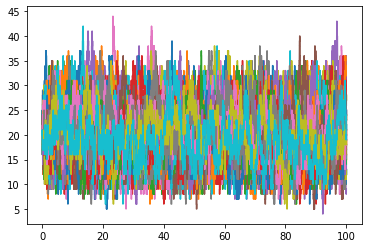

95% CI for p(19) is: (0.05, 0.15524999999999992)


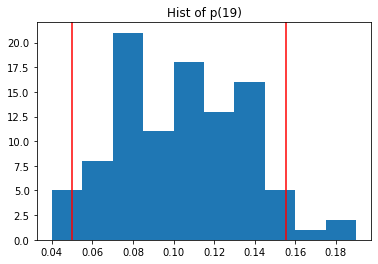

95% CI for p(20) is: (0.03475, 0.15524999999999992)


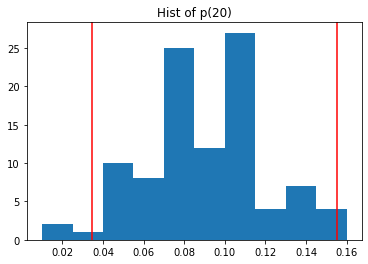

95% CI for p(21) is: (0.04, 0.16)


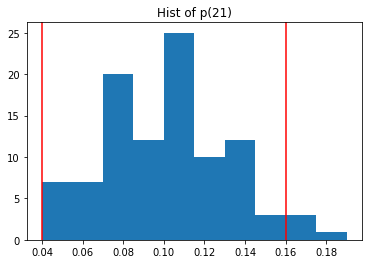

In [5]:
bootstrap([19,20,21],20,[20,1],100,100,100,plot=True,printing=True);

# Confidence Intervals: Width v True value

Plot relationship between width of bootstrapped confidence intervals and true value of stationary probabilities:

CI Width $ \propto $ p(1-p), where p is the true stationary prob. for state x.

We find CI's for the first 10 states for a range of parameter values, plotting CI width vs true stationary dist (Poi(k1/k2)), plotting to show the pattern:

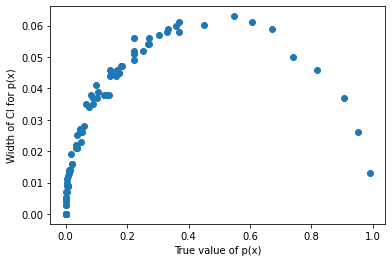

In [6]:
def width(intervals):
    return [interval[1] - interval[0] for interval in intervals]

# estimate 
x_max = 10
k2 = 1
true_p = []
variance = []
#for k1 in np.linspace(0,10,100):
for k1 in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2,3,5]:
    estimates, intervals = bootstrap([x for x in range(x_max)],0,[k1,k2],100,1000,1000)
    # compute widths of intervals
    widths = width(intervals)
    variance.extend(widths)
    # plot against true stat dist
    dist = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_max)]
    true_p.extend(dist)
plt.scatter(true_p,variance)
plt.xlabel("True value of p(x)")
plt.ylabel("Width of CI for p(x)")
plt.show()

However, the width of the CI is a measure of absolute error. To get a measure of relative error we can divide the width by the true value.

This shows that the error decreases rapidly as p(x) increases from 0, since we now observe sufficiently many events to estimate well, but higher probabilities do not give a significant improvement (as we already observe enough events in a sample for a good estimate). The exteme case where no events are observed can be seen: the prob is estimated as 0, and the CI has no width as there is no way to estimate the uncertainty of the estimate.

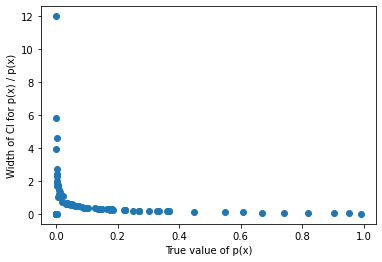

In [8]:
# estimate 
x_max = 10
k2 = 1
true_p = np.array([])
relative_var = np.array([])
for k1 in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2,3,5]:
    # true stat dist
    dist = np.array([(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(x_max)])
    true_p = np.append(true_p, dist)
    # find CI
    estimates, intervals = bootstrap([x for x in range(x_max)],0,[k1,k2],100,1000,1000)
    # compute widths of intervals, find relative error
    widths = np.array(width(intervals))
    scaled = widths / dist
    relative_var = np.append(relative_var, scaled)
plt.scatter(true_p,relative_var)
plt.xlabel("True value of p(x)")
plt.ylabel("Width of CI for p(x) / p(x)")
plt.show()

# Create LP

In [9]:
def birth_death_LP(indices, pl, pu, printing=False):
    """
    indices = list of indices of equations/rows of Q to use for constraints
    NOTE: index equations from zero
    pl = array of lower bounds on p (enough for equations used)
    pu = array of upper bounds on p ( == )

    returns:
    lower bound on k1
    upper bound on k1
    """

    # number of equations used (rows of Q) = largest equation index (+1)
    N = max(indices) + 1

    # NOTE: define one extra row and cut off, since square matrix would leave out
    # upper diagonal elements on Nth row

    # create Qr matrices
    Q1 = (np.diag([-1 for x in range(0,N+1)],0) + np.diag([1 for x in range(0,N)],-1))[:-1, :]
    Q2 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]

    # set rows to zero if equations not wanted
    for i in range(N):
        if i not in indices:
            Q1[i,:] = 0
            Q2[i,:] = 0

    # NOTE: add error for when pl, pu too small for number of equations
    # equation i involves p(i + 1)
    # so max index i => need bounds on p(i + 1), need length i + 2 = N + 1 pl/pu

    # define bounds 
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # NOTE: truncate to N + 1, as tridiagonal, so Nth equation has N+1 p's

    # Construct the problem.
    k1 = cv.Variable(1)
    k2 = 1
    z1 = cv.Variable(N + 1)
    z2 = cv.Variable(N + 1)
    objective_max = cv.Maximize(k1)
    objective_min = cv.Minimize(k1)
    constraints = [Q1 @ z1 + Q2 @ z2 == 0,
                k1 >= 0,
                z1 >= k1 * pl,
                z1 <= k1 * pu,
                z2 >= k2 * pl,
                z2 <= k2 * pu]
    prob_max = cv.Problem(objective_max, constraints)
    prob_min = cv.Problem(objective_min, constraints)   

    # Print result.
    result_max = prob_max.solve()
    if printing:
        print("\nThe upper bound is", prob_max.value)
        print("A solution k1 is")
        print(k1.value)
    max_bound = k1.value
    result_min = prob_min.solve()
    if printing:
        print("\nThe lower bound is", prob_min.value)
        print("A solution k1 is")
        print(k1.value)
    min_bound = k1.value
    
    return prob_min.value, prob_max.value

## Test

In [18]:
# create confidence intervals
k1 = 5
x_max = 12
estimates, intervals = bootstrap([x for x in range(x_max)],0,[k1,1],100,2000,2000)

# create bounds on p
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]

# use as bounds for BD LP
lb, ub = birth_death_LP([0,1,2,8,9,10],pl,pu,printing=True)


The upper bound is 6.536423851101928
A solution k1 is
[6.53642385]

The lower bound is 4.081081077493431
A solution k1 is
[4.08108108]


# Width of solution interval v equation used

Equation n (row n of Q) involves p(n-1), p(n), p(n+1). As seen, the width of bounds on p depends on their true values.

- plot width of solution bounds against the single equation used to solve the LP
- plot upper and lower bounds against equation (same information, different visual)

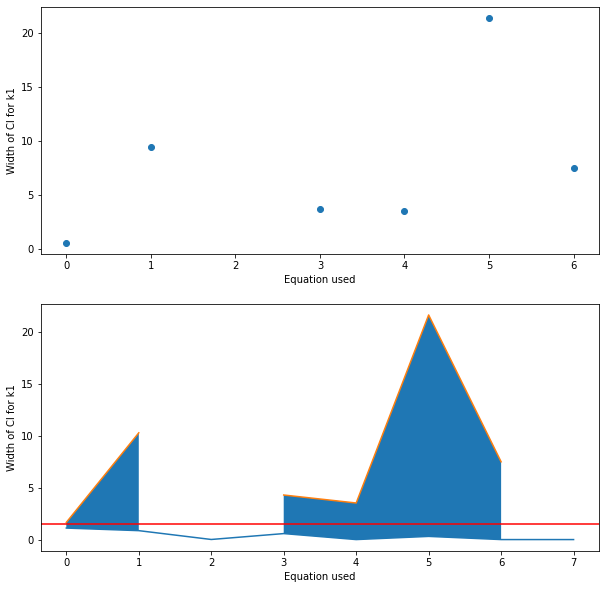

In [46]:
k1 = 1.5
solution_width = []
upper_bounds = []
lower_bounds = []
equation = []
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],0,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# using equation n: solve LP
for n in range(8):
    lb, ub = birth_death_LP([n],pl,pu)
    try:
        solution_width.append(ub - lb)
        upper_bounds.append(ub)
        lower_bounds.append(lb)
        equation.append(n)
    except TypeError:
        print(f"Type error for equation {n}, ub {ub}, lb {lb}")
# plot: scatter of width, lines of upper and lower bounds vs equation used
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))
ax[0].scatter(equation, solution_width)
ax[0].set(xlabel="Equation used", ylabel="Width of CI for k1")
ax[1].plot(equation, lower_bounds)
ax[1].plot(equation, upper_bounds)
ax[1].set(xlabel="Equation used", ylabel="Width of CI for k1")
ax[1].fill_between(equation, lower_bounds, upper_bounds)
ax[1].axhline(k1, color="red")
plt.show()

### Stationary distribution: Poisson(k1 / k2)

For integer k1 / k2 may be bi-modal, leading to solutions unbounded above when using equations involving the bi-modal states (as p(x)'s have same value, so cancel???) even though they should contain the most information.

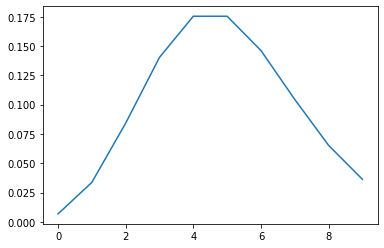

In [50]:
# distribution (to see mode)
k1 = 5
k2 = 1
dist = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(10)]
plt.plot(dist)

To find the best equation to use (for given parameters) follow the above and record the equation giving the smallest solution interval, repeat for a large number of samples and produce the distribution of best equations:

In [72]:
def equation_distribution(params, M, N):
    """
    params = [k1, k2]
    M = number of samples
    N = number of equations to use
    """
    # fixed parameters
    k1 = params[0]
    k2 = params[1]
    # store best equations
    best_equation = []
    for i in range(M):
        # store values
        solution_width = []
        upper_bounds = []
        lower_bounds = []
        equation = []
        # compute CI bounds on p(x)'s
        estimates, intervals = bootstrap([x for x in range(N + 1)],0,[k1,k2],100,1000,1000)
        pl = [intv[0] for intv in intervals]
        pu = [intv[1] for intv in intervals]
        # using equation n: solve LP
        for n in range(N):
            lb, ub = birth_death_LP([n],pl,pu)
            try:
                solution_width.append(ub - lb)
                upper_bounds.append(ub)
                lower_bounds.append(lb)
                equation.append(n)
            except TypeError:
                print(f"Type error for equation {n}, ub {ub}, lb {lb}")
        # find equation of minimum solution width
        # (NOTE: equation should be equal to index, but making sure)
        best_equation.append(equation[np.argmin(solution_width)])
    # plot distribution of best equation: proportion of equation #'s among best
    eqn_dist = [best_equation.count(x) / M for x in range(N)]
    plt.plot(eqn_dist)

    return eqn_dist

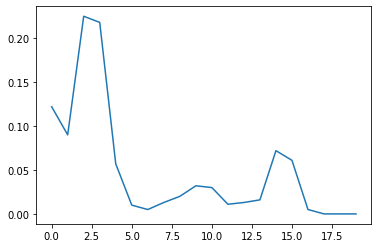

In [67]:
#

[0.47,
 0.22,
 0.07,
 0.0,
 0.0,
 0.0,
 0.01,
 0.0,
 0.0,
 0.01,
 0.02,
 0.13,
 0.07,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

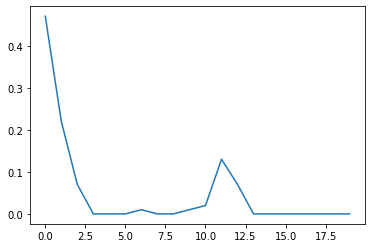

In [73]:
equation_distribution([4,1],100,20)

[0.78,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02,
 0.19,
 0.01,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

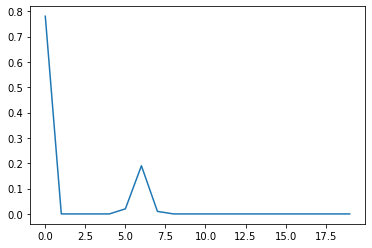

In [86]:
equation_distribution([1,1],100,20)

Change to find the equation of minimum solution width that contains the true parameter value. Add this check to see if the bumps in later states are due to small but wrong solution intevals:

In [88]:
def equation_distribution_accurate(params, M, N):
    """
    params = [k1, k2]
    M = number of samples
    N = number of equations to use
    """
    # fixed parameters
    k1 = params[0]
    k2 = params[1]
    # store best equations
    best_equation = []
    for i in range(M):
        # compute CI bounds on p(x)'s
        estimates, intervals = bootstrap([x for x in range(N + 1)],0,[k1,k2],100,1000,1000)
        pl = [intv[0] for intv in intervals]
        pu = [intv[1] for intv in intervals]
        # store best equation and width
        min_width = math.inf
        min_eqn = -1
        for n in range(N):
            # solve using equation n: find width
            lb, ub = birth_death_LP([n],pl,pu)
            width = ub - lb
            # if valid solution interval and min: update min
            if lb <= k1 and k1 <= lb and width < min_width:
                min_width = width
                min_eqn = n
        # record best equation
        best_equation.append(min_eqn)
    # plot distribution of best equation: proportion of equation #'s among best
    eqn_dist = [best_equation.count(x) / M for x in range(N)]
    plt.plot(eqn_dist)

    return eqn_dist

[0.735, 0.004, 0.0, 0.0, 0.0, 0.046, 0.212, 0.003, 0.0, 0.0, 0.0]

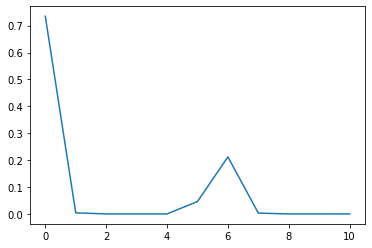

In [92]:
equation_distribution([1,1],1000,11)

See that the peak at later values is still present, so these equations do genuinely give the best solution interval a proportion of the time.

Plot the distribution of best equations for a range of parameter values: k1/k2 = 0.1, 0.25,  ..., 12, with a red line indicating k1/k2, the mode of the stationary distribution (Poi(k1/k2)):

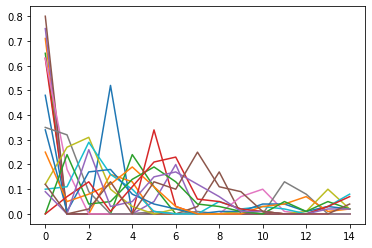

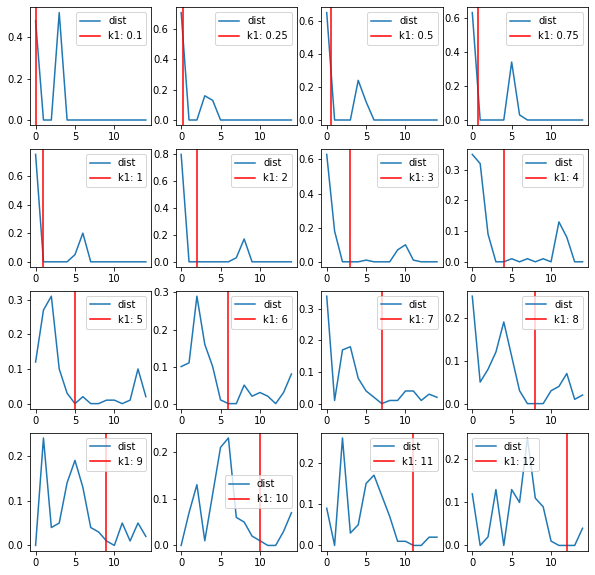

In [117]:
distributions = []
k1_list = [0.1,0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10,11,12]
for k1 in k1_list:
    dist = equation_distribution([k1,1],100,15)
    distributions.append(dist)

nrows = 4
ncols = 4
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        idx = i * nrows + j
        k1 = k1_list[idx]
        ax[i,j].plot(distributions[idx])
        ax[i,j].axvline(k1, color='red')
        ax[i,j].legend(['dist',f'k1: {k1}'])
plt.show()

The red lines at k1/k2 show the mode of the stationary distribution, states at/around this value will have the largest probability values and so the smallest confidence intervals (as seen before). Equation n for this process uses states n + 1, n, n - 1, so we would expect equations around the red line to give smaller solution intevals.

However, we see that most of the time the equations around the red line are not likely to give the best solution, often never. This is suprising, but may be due to problems with bi-model values from using discrete values from the poisson stationary distribution: as shown before this leads to 2 values at the peak of the stationary distribution being equal, leading to no upper solution bound (perhaps as they cancel out in equations).

$\frac{k1}{k2} \in \mathbb{N} \implies P(X = \frac{k1}{k2}) = P(X = \frac{k1}{k2} + 1) \text{ for } X \sim Poi(\frac{k1}{k2})$ 

So states $ \frac{k1}{k2} $ and $ \frac{k1}{k2} +1 $ have the same stationary distribtuion values.

We now look at distributions of best equations for parameter values that do not give bi-modal distributions:

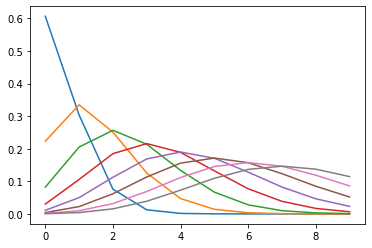

In [134]:
# distribution (to see mode)
for k1 in [x + 0.5 for x in range(8)]:
    k2 = 1
    dist = [(k1 / k2)**k * math.exp(-k1 / k2) / math.factorial(k) for k in range(10)]
    plt.plot(dist)
plt.show()

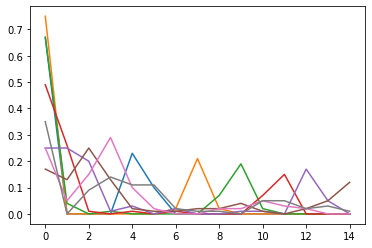

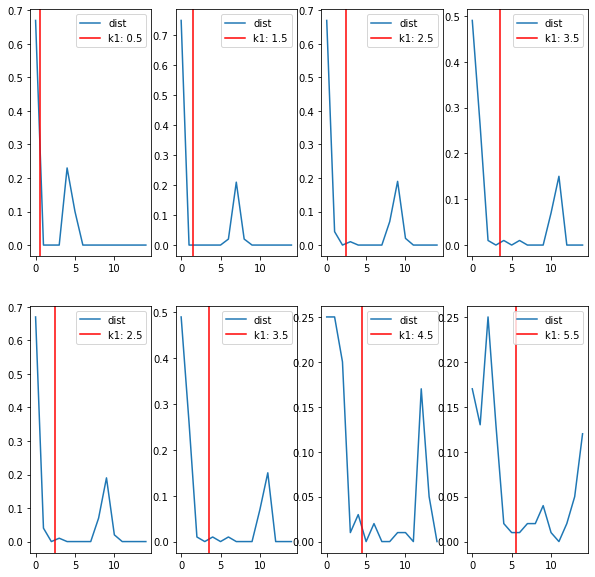

In [135]:
distributions_unimodal = []
k1_list = [x + 0.5 for x in range(8)]
for k1 in k1_list:
    dist = equation_distribution([k1,1],100,15)
    distributions_unimodal.append(dist)

nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        idx = i * nrows + j
        k1 = k1_list[idx]
        ax[i,j].plot(distributions_unimodal[idx])
        ax[i,j].axvline(k1, color='red')
        ax[i,j].legend(['dist',f'k1: {k1}'])
plt.show()

Now see that small peaks appear around the modal states, and they do sometimes give the best solution interval when the bi-modal issue does not arise. However, we see that the much larger peak at states far away from the mode states still remains.

# Multiple equations

In practice will use multiple equations, usually as many as possible, so want to see how many is enough.

- simulate bounds
- solve LP using 1st equation, 1st and 2nd eqns, ...
- plot plot width of solution interval against total # used (as well as visual intervals for clarity)
- repeat for several bounds to see trend

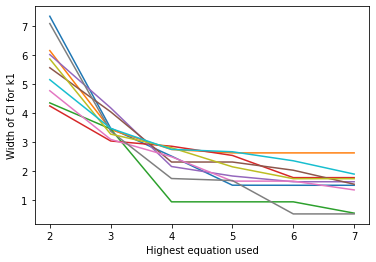

In [81]:
k1 = 5
for k in range(10):
    # compute CI bounds on p(x)'s
    estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]
    # store results
    solution_width = []
    equation = []
    # solve LP using equations [0,1,...,n-1] for increasing n values
    for n in range(2,8):
        lb, ub = birth_death_LP([x for x in range(n)],pl,pu)
        try:
            solution_width.append(ub - lb)
            equation.append(n)
        except TypeError:
            print(f"Type error for equation {n}")
    plt.plot(equation,solution_width)
plt.xlabel("Highest equation used")
plt.ylabel("Width of CI for k1")
plt.show()

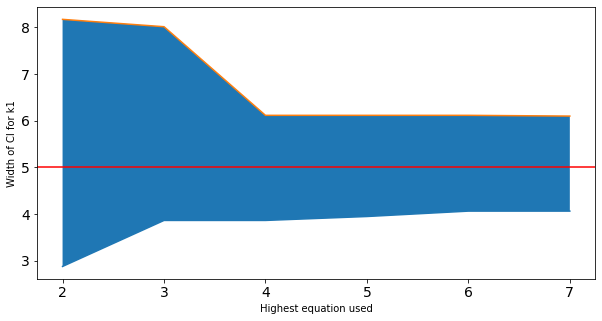

In [82]:
k1 = 5
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# store results
ubs = []
lbs = []
equation = []
# solve LP using equations [0,1,...,n-1] for increasing n values
for n in range(2,8):
    try:
        lb, ub = birth_death_LP([x for x in range(n)],pl,pu)
    except:
        lb = 0
        ub = 30
    if ub > 30:
        ub = 30
    ubs.append(ub)
    lbs.append(lb)
    equation.append(n)
fig, ax = plt.subplots(figsize=(10,5))
plt.tick_params(labelsize=14)
plt.xlabel("Highest equation used")
plt.ylabel("Width of CI for k1")
ax.plot(equation,lbs)
ax.plot(equation,ubs)
ax.fill_between(equation,lbs,ubs)
ax.axhline(k1, color="red")

Also try starting with e.g. 10th equation, then 9th and 10th equations, ... adding in reverse:

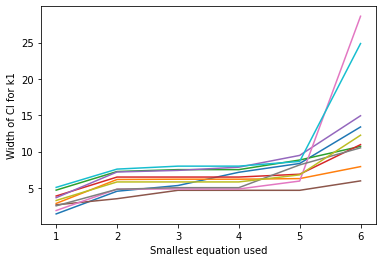

In [83]:
k1 = 5
for k in range(10):
    # compute CI bounds on p(x)'s
    estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
    pl = [intv[0] for intv in intervals]
    pu = [intv[1] for intv in intervals]
    # store results
    solution_width = []
    equation = []
    # solve LP using equations [0,1,...,n-1] for increasing n values
    for n in range(2,8):
        lb, ub = birth_death_LP([8 - x for x in range(n)],pl,pu)
        try:
            solution_width.append(ub - lb)
            equation.append(7 - (n-1))
        except TypeError:
            print(f"Type error for equation {n}")
    plt.plot(equation,solution_width)
plt.xlabel("Smallest equation used")
plt.ylabel("Width of CI for k1")
plt.show()

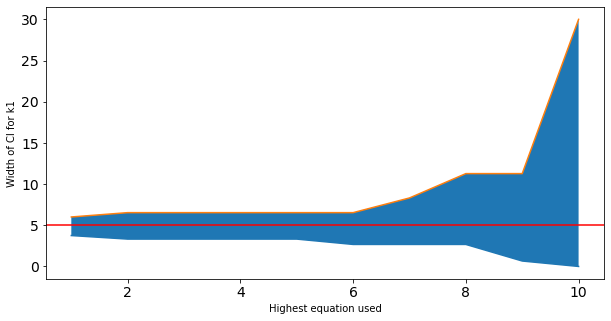

In [84]:
k1 = 5
max_eqn = 10
# compute CI bounds on p(x)'s
estimates, intervals = bootstrap([x for x in range(12)],5,[k1,1],100,1000,1000)
pl = [intv[0] for intv in intervals]
pu = [intv[1] for intv in intervals]
# store results
ubs = []
lbs = []
equation = []
# solve LP using equations [0,1,...,n-1] for increasing n values
for n in range(max_eqn,0,-1):
    try:
        lb, ub = birth_death_LP([x for x in range(n,max_eqn + 1)],pl,pu)
    except:
        lb = 0
        ub = 30
    if ub > 30:
        ub = 30
    ubs.append(ub)
    lbs.append(lb)
    equation.append(n)
fig, ax = plt.subplots(figsize=(10,5))
plt.tick_params(labelsize=14)
plt.xlabel("Highest equation used")
plt.ylabel("Width of CI for k1")
ax.plot(equation,lbs)
ax.plot(equation,ubs)
ax.fill_between(equation,lbs,ubs)
ax.axhline(k1, color="red")